In [2]:
import sys
sys.path.append('..')
from utils.visualization import *
import matplotlib.pyplot as plt
import os, pickle, json
from utils.visualization import reclusive_file_search, read_data
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

## logging

In [1]:
fn = '/home/jhyang/WORKSPACES/CODES/fpoly/package/log_pt.txt'
with open(fn, 'rb') as f:
    lines = f.read().decode('utf-8').split('\n')[:-1]

os.rename(fn, fn+'.bkup')
new_lines = []
pbar = False
for line in lines:
    if '\r' in line:
        new_lines.append(line.split('\r')[-1])
    else:
        new_lines.append(line)

with open(fn, 'w') as f:
    f.write('\n'.join(new_lines))
    

# Check CV output

In [ ]:
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/scratch_n2i-02'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/finetune_n2i-01'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/finetune_n3c2'
cv = False
epoch = 500
outputs = {}
ensembles = {}
for model in ['mol','graph','concat']:
    print(model,'-'*50)
    output = {}
    ensemble = {}
    path_model = os.path.join(root, model)
    if not os.path.isdir(path_model): continue
    for tag in sorted(os.listdir(path_model)):
        path_tag = os.path.join(path_model, tag)
        output[tag] = {'train':[], 'valid':[]}
        ensemble[tag] = {'target':[], 'pred':[]}
        for i in range(100):
            dn = os.path.join(path_tag, f'c{"v" if cv else ""}_{i:04d}')
            if not os.path.isdir(dn):
                continue
            for ds in ['train','valid']:
                dfn = os.path.join(dn, f'{epoch:05d}.{ds}.pkl')
                if not os.path.isfile(dfn): continue
                out = read_data(dfn)
                t, p = out['target'], out['pred']
    #            output[tag][ds].append([r2_score(t, p), mean_absolute_error(t, p), np.sqrt(mean_squared_error(t, p))])
                output[tag][ds].append([r2_score(t, p), np.sqrt(mean_squared_error(t, p))])
            dfn = os.path.join(dn, f'{epoch:05d}.test.pkl')
            if not os.path.isfile(dfn): continue
            out = read_data(dfn)
            t, p = out['target'], out['pred']
            ensemble[tag]['pred'].append(p)
            ensemble[tag]['target'] = t

        dfn = os.path.join(path_tag, f'{epoch:05d}.test.pkl')
        if not os.path.isfile(dfn): continue
        out = read_data(dfn)
        t, p = out['target'], out['pred']
        output[tag]['test'] = r2_score(t, p), np.sqrt(mean_squared_error(t, p))
    outputs[model] = output
    ensembles[model] = ensemble
    for tag, data in output.items():
        printing = f'{tag:12s} ({len(data["train"])}) '
        for ds in ['train','valid']:
            v = data[ds]
    #        printing += '{:6.3f} {:5.3f}  {:5.2f} {:4.2f}  {:5.2f} {:4.2f} | '.format(*np.vstack([np.mean(v, axis=0), np.std(v, axis=0)]).T.reshape(-1))
            printing += '| {:6.3f} {:5.3f}  {:5.2f} {:4.2f} '.format(*np.vstack([np.mean(v, axis=0), np.std(v, axis=0)]).T.reshape(-1))
        printing += '| {:6.3f}  {:5.2f} '.format(*data['test'])
        t = ensemble[tag]['target']
        p = np.median(ensemble[tag]['pred'], axis=0)
        printing += '/ {:6.3f} {:5.2f} '.format(r2_score(t, p), np.sqrt(mean_squared_error(t,p)))
        p = np.mean(ensemble[tag]['pred'], axis=0)
        printing += '/ {:6.3f} {:5.2f}'.format(r2_score(t, p), np.sqrt(mean_squared_error(t,p)))
        print(printing)

In [4]:
df = pd.read_csv('../dataset/fpolymers_221123.csv', index_col=0)
df = df[~df['TG'].isna()]
wdf = df[[f'FR_{x}' for x in 'ABCDE']].fillna(0)
wcount = 5 - (wdf == 0).sum(axis=1)
class_data = {}
for id, row in df.iterrows():
    s = row[[f'SMILES_{x}' for x in 'ABCDE']]
    w = wdf.loc[id].values
    w = w / np.sum(w)
    m = w != 0
    class_data[id] = {
        'smiles': s[m].values,
        'weight': w[m]
    }

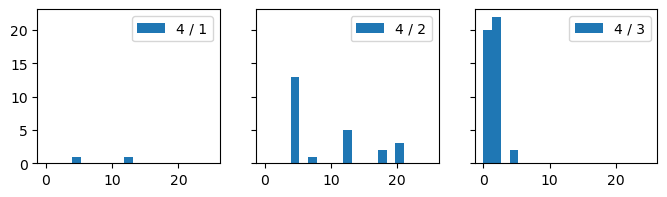

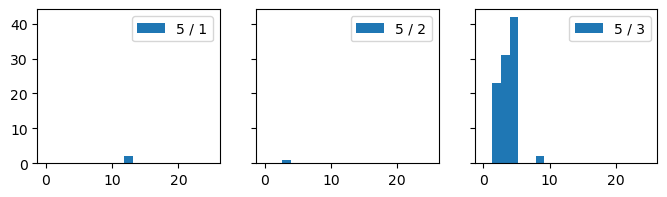

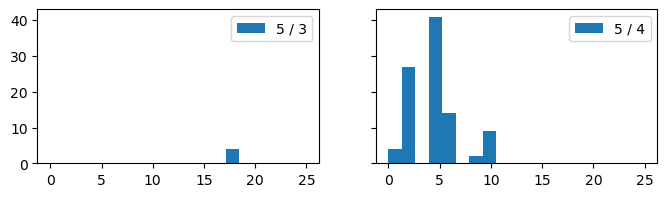

In [5]:
train_group = {i:['All'] for i in df.index}
train_group_list = ['All','F','C','c1','c2','Fc1','Cc1','Fc2','Cc2']
train_group_list = ['All','c1','c2']
test_group = {i:['All'] for i in df.index}
test_group_list1 = ['All','4-2','4-3','5-3']
test_group_list2 = ['All','5-a','5-b','5-c']
cluster_ids = ['FA-00298', 'FA-00301', 'FA-00353', 'FA-00411', 'FA-00412',
        'FA-00413', 'FA-00414', 'FA-00416', 'FA-00417', 'FA-00418',
        'FA-00419', 'FA-00420', 'FA-00421', 'FA-00422', 'FA-00424',
        'FA-00425', 'FA-00426', 'FA-00428', 'FA-00429', 'FA-00430',
        'FA-00431', 'FA-00432', 'FA-00433', 'FA-00434', 'FA-00435',
        'FA-00436', 'FA-00438', 'FA-00439', 'FA-00441', 'FA-00442',
        'FA-00443', 'FA-00444', 'FA-00445', 'FA-00447', 'FA-00448',
        'FA-00484']
for dvi in [3, 4, 5]:
    trained_smiles = []
    for id in df.index[wcount <= dvi]:
        for s in class_data[id]['smiles']:
            if s not in trained_smiles: trained_smiles.append(s)
        fgroup = 'F' if 'F' in ' '.join(class_data[id]['smiles']) else 'C'
        cgroup = 'c1' if id in cluster_ids else 'c2'
        if fgroup not in train_group[id]:
            train_group[id].append(fgroup)
        if cgroup not in train_group[id]:
            train_group[id].append(cgroup)
        if fgroup + cgroup not in train_group[id]:
            train_group[id].append(fgroup + cgroup)
            
    counts = {i:[] for i in range(1,6)}
    cinfos = {}
    for id in df.index[wcount > dvi]:
        c = np.sum([s in trained_smiles for s in class_data[id]['smiles']])
        counts[c].append(id)
        rate = []
        count = []
        for tid in df.index[wcount <= dvi]:
            c = [s in class_data[id]['smiles'] for s in class_data[tid]['smiles']]
            r = np.sum(c) / len(class_data[id]['smiles'])
            rate.append(r)
            count.append(np.sum(c))
        rate = np.array(rate)
        count = np.array(count)

        k = [np.sum([i ** j for j in range(1, np.sum(rate == i))]) for i in np.unique(rate)]
        l = len(class_data[id]['smiles'])
        m = np.max(count)
        n = np.sum(np.max(count) == count)
        cinfos[id] = {'l':l, 'w':k, 'm':m, 'n':n, 'rate':rate, 'count':count}
        g = f'{l}-{m}'
        if g == '5-4':
            if n < 4:
                g = '5-a'
            elif n < 8:
                g = '5-b'
            else:
                g = '5-c'
        if g not in test_group_list1 and g not in test_group_list2: continue
        test_group[id].append(g)
    
    n = np.array([v['l'] for v in cinfos.values()])
    m = np.array([v['m'] for v in cinfos.values()])
    c = np.array([v['n'] for v in cinfos.values()])
    um = np.sort(np.unique(m))
    for i in range(dvi+1, 6):
        mask = n == i
        f, axs = plt.subplots(1,len(um),figsize=(8,2), sharey=True)
        for j, ax in zip(um, axs):
            _mask = mask & (j == m)
            ax.hist(c[_mask], bins=np.linspace(0,25,20), label=f'{i} / {j}')
            ax.legend(loc='upper right')

In [390]:
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/bo_r2_failed/finetune_n3c1i-3'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_3/finetune_n3c1i-2'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_3/finetune_n3c1i-3'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_3/finetune_n3c1'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_3/scratch_n3c1'
epoch = 'best'#f'{500:05d}'
outputs = {}
rmse = False
for model in ['mol','graph','concat']:
    print('== ',model,'='*50)
    output = {}
    ensemble = {}
    path_model = os.path.join(root, model)
    if not os.path.isdir(path_model): continue
    for tag in sorted(os.listdir(path_model)):
        path_tag = os.path.join(path_model, tag)
        output[tag] = {'train':{g:[] for g in train_group_list}, 
                       'valid':{g:[] for g in train_group_list}}
#        if c_12:
#            output[tag]['test'] = {g:[] for g in test_group_list1}
#        else:
#            output[tag]['test'] = {g:[] for g in test_group_list2}
        for i in range(100):
            dn = os.path.join(path_tag, f'cv_{i:04d}')
            if not os.path.isdir(dn):
                continue
            for ds in ['train','valid']:
                data = {g:[] for g in train_group_list}
                dfn = os.path.join(dn, f'{epoch}.{ds}.pkl')
                if not os.path.isfile(dfn): continue
                out = read_data(dfn)
                for id, t, p in zip(out['id'], out['target'], out['pred']):
                    for g in train_group[id]:
                        if g not in train_group_list: continue
                        data[g].append([t, p])
                for g, v in data.items():
                    if g not in train_group_list: continue
                    if len(v) > 1:
                        t, p = np.array(v).T
                        output[tag][ds][g].append([r2_score(t, p), np.sqrt(mean_squared_error(t, p)), len(t)])
                        _r2, _rmse, _l = r2_score(t, p), np.sqrt(mean_squared_error(t, p)), len(t)
                    elif len(v) == 1:
                        output[tag][ds][g].append([0,np.abs(v[0][0] - v[0][1]), 1])
                    else:
                        output[tag][ds][g].append([0,0,0])
    outputs[model] = output
    for tag, d1 in output.items():
        for i, (ds, d2) in enumerate(d1.items()):
            for j, (g, d3) in enumerate(d2.items()):
                if i == 0 and j == 0:
                    printings = [f'{tag:12s} | '] + [f'Fold: {k:2d}     | ' for k in range(len(d3))] + ['Aerage:      | ']
                printings[0] += f'{g:>13s}'
                for k, v in enumerate(d3):
                    val = v[int(rmse)]
                    count = v[2]
                    if rmse and val > 999:
                        printings[k+1] += f'{">1000":>7s} ({v[2]:3d})'
                    elif not rmse and val < -99:
                        printings[k+1] += f'{"<-100":>7s} ({v[2]:3d})'
                    else:
                        printings[k+1] += f'{v[int(rmse)]:7.3f} ({v[2]:3d})'
                v = np.array(d3)
                m = v.T[int(rmse)] != 0
                if np.sum(m) != 0:
                    avg = np.mean(v[m], axis=0)[int(rmse)]
                    std = np.std(v[m], axis=0)[int(rmse)]
                    if rmse and avg > 999:
                        printings[-1] += f'{">1000":>7s}'
                    elif not rmse and avg < -99:
                        printings[-1] += f'{"<-100":>7s}'
                    else:
                        printings[-1] += f'{avg:7.3f}'
                    if std > 99:
                        printings[-1] += f' {">100":>5s}'
                    else:
                        printings[-1] += f' {std:5.3f}'
                else:
                    printings[-1] += f'{0.0:7.3f} {0.0:5.3f}'
            for j in range(len(printings)):
                printings[j] += ' | '
        print(printings[0])
        print('-'*len(printings[0]))
        for p in printings[1:-1]:
            print(p)
        print('-'*len(printings[0]))
        print(printings[-1])
        print()
                    

==  mol ==================================================
mult_add_dnn |           All           c1           c2 |           All           c1           c2 | 
---------------------------------------------------------------------------------------------------
Fold:  0     |   0.956 (196)  0.882 ( 22)  0.956 (174) |   0.697 ( 98) -4.296 ( 14)  0.679 ( 84) | 
Fold:  1     |   0.988 (196)  0.970 ( 28)  0.987 (168) |   0.710 ( 98) -0.553 (  8)  0.740 ( 90) | 
Fold:  2     |   0.969 (196)  0.966 ( 22)  0.964 (174) |   0.645 ( 98) -0.214 ( 14)  0.663 ( 84) | 
---------------------------------------------------------------------------------------------------
Aerage:      |   0.971 0.013  0.939 0.041  0.969 0.013 |   0.684 0.028 -1.688 1.850  0.694 0.033 | 

==  graph ==================================================
mult_add_cg  |           All           c1           c2 |           All           c1           c2 | 
-------------------------------------------------------------------------------

In [4]:
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/bo_r2_failed/finetune_n3c1i-3'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_3/finetune_n3c1i-2'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_3/finetune_n3c1i-3'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/finetune_e3i-3'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/finetune_e3'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/scratch'
epoch = 'best'#f'{500:05d}'
outputs = {}
summary = False
for model in ['concat']:
    print('== ',model,'='*50)
    output = {}
    path_model = os.path.join(root, model)
    if not os.path.isdir(path_model): continue
    for tag in sorted(os.listdir(path_model)):
        path_tag = os.path.join(path_model, tag)
        output[tag] = {'train':[], 'valid':[], 'test':[]}
        for i in range(100):
            dn = os.path.join(path_tag, f'n_{i:03d}')
            if not os.path.isdir(dn):
                continue
            for ds in ['train','valid', 'test']:
                dfn = os.path.join(dn, f'{epoch}.{ds}.pkl')
                if not os.path.isfile(dfn): continue
                out = read_data(dfn)
                _, t, p = out['id'], out['target'], out['pred']
                output[tag][ds].append([r2_score(t, p), np.sqrt(mean_squared_error(t, p)), len(t)])
    outputs[model] = output
    for tag, d1 in output.items():
        ps =  [f'{tag:8s} | ' + f'  {"Train (R2 / RMSE)":20} |   {"Valid (R2 / RMSE)":20} | Test (R2 / RMSE)']
        ps += [f'Fold: {k:2d} | ' for k in range(len(d1['train']))]
        ps += ['AVG:     | ']
        ps += ['STD:     | ']
        for i, (ds, d2) in enumerate(d1.items()):
            for j, d in enumerate(d2):
                ps[j+1] += f'{d[0]:7.3f} / {d[1]:6.2f} {f"[{d[2]:d}]":5s} | '
            avg = np.mean(d2, axis=0)
            std = np.std(d2, axis=0)
            ps[-2] += '{:7.3f} / {:6.2f} NUM | '.format(*avg)
            ps[-1] += ' ±{:5.3f} /  ±{:4.2f} NUM | '.format(*std)
        print(ps[0])
        if not summary:
            print('-'*len(ps[1]))
            for p in ps[1:-2]:
                print(p)
        print('-'*len(ps[1]))
        print(ps[-2].replace('NUM','{:5s}'.format(f'[{len(d2):d}]')))
        print(ps[-1].replace('NUM','{:5s}'.format(f'[{len(d2):d}]')))
        print()
                    

==  concat ==================================================
dual_cg  |   Train (R2 / RMSE)    |   Valid (R2 / RMSE)    | Test (R2 / RMSE)
--------------------------------------------------------------------------------------
Fold:  0 |   0.920 /   8.77 [196] |   0.800 /  11.89 [50]  |   0.532 /  12.06 [48]  | 
Fold:  1 |   0.922 /   8.57 [197] |   0.529 /  19.31 [49]  |   0.582 /  11.40 [48]  | 
Fold:  2 |   0.916 /   8.45 [197] |   0.578 /  21.51 [49]  |   0.238 /  15.38 [48]  | 
Fold:  3 |   0.945 /   7.03 [197] |   0.803 /  13.66 [49]  |   0.596 /  11.20 [48]  | 
Fold:  4 |   0.969 /   5.31 [197] |   0.623 /  18.87 [49]  |   0.335 /  14.37 [48]  | 
--------------------------------------------------------------------------------------
AVG:     |   0.934 /   7.63 [5]   |   0.667 /  17.05 [5]   |   0.457 /  12.88 [5]   | 
STD:     |  ±0.020 /  ±1.31 [5]   |  ±0.114 /  ±3.64 [5]   |  ±0.144 /  ±1.68 [5]   | 

dual_tf  |   Train (R2 / RMSE)    |   Valid (R2 / RMSE)    | Test (R2 / RMSE

In [376]:
def get_high_score(path):
    global root
    with open(os.path.join(root, path, 'log_bo.txt')) as f:
        lines = f.read().split('\n')[:-1]
        _ls = [l.split()[9:14] for l in lines]
        score = [float(l[0]) + float(l[3]) - 0.05 * (float(l[1]) + float(l[4])) for l in _ls]
        ls = np.array([f'{s:8.4f} / {l[:8]} {l[40:]}' for l, s in zip(lines, score)])
    ids = []
    for fn in os.listdir(os.path.join(root, path)):
        if 'iBO' in fn:
            ids.append(int(fn.split('.')[0].replace('iBO','')))
    ids = np.sort(np.unique(ids))
    print(ls[ids])
    return path
path = get_high_score(f'{model}/dual_cg/n_004')

['  0.4745 / iBO:   0 |   0.867    5.71 |   0.570   13.54 |   0.454    8.98 - best'
 '  0.4755 / iBO:   1 |   0.899    4.36 |   0.507   14.25 |   0.361    8.43 - best'
 '  0.6345 / iBO:   3 |   0.941    3.31 |   0.522   13.26 |   0.150    9.67 - best'
 '  0.6160 / iBO:   4 |   0.882    5.00 |   0.607   12.46 |   0.440    8.50'
 '  0.6545 / iBO:  10 |   0.939    3.69 |   0.541   12.82 |   0.014   10.44 - best'
 '  0.7600 / iBO:  11 |   0.976    2.52 |   0.570   13.20 |  -0.088   10.84 - best'
 '  0.7485 / iBO:  15 |   0.969    2.18 |   0.563   13.49 |   0.385    9.42'
 '  0.8705 / iBO:  19 |   0.968    3.06 |   0.639   11.67 |   0.152   11.06 - best'
 '  0.8825 / iBO:  21 |   0.979    2.98 |   0.621   11.37 |   0.182   10.73 - best'
 '  0.8190 / iBO:  24 |   0.962    3.07 |   0.613   12.05 |   0.174   10.22'
 '  0.8010 / iBO:  25 |   0.967    2.93 |   0.612   12.63 |   0.206   10.92'
 '  0.8440 / iBO:  28 |   0.979    2.40 |   0.600   12.30 |   0.139   11.17'
 '  0.9250 / iBO:  30 |   0

In [5]:
n = 30
pfx = f'iBO{n:03d}'
for fn in os.listdir(os.path.join(root, path)):
    if pfx in fn:
        os.system('cp {} {}'.format(os.path.join(root, path, fn), 
                  os.path.join(root, path, fn.replace(pfx, 'best'))))

NameError: name 'path' is not defined

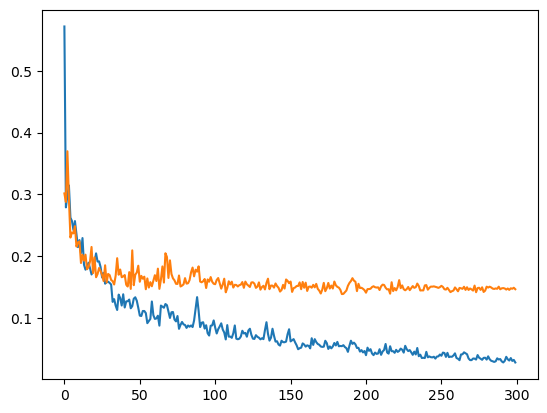

In [379]:
for l in np.loadtxt(os.path.join(root, path, 'best.loss.txt')):
    plt.plot(l)

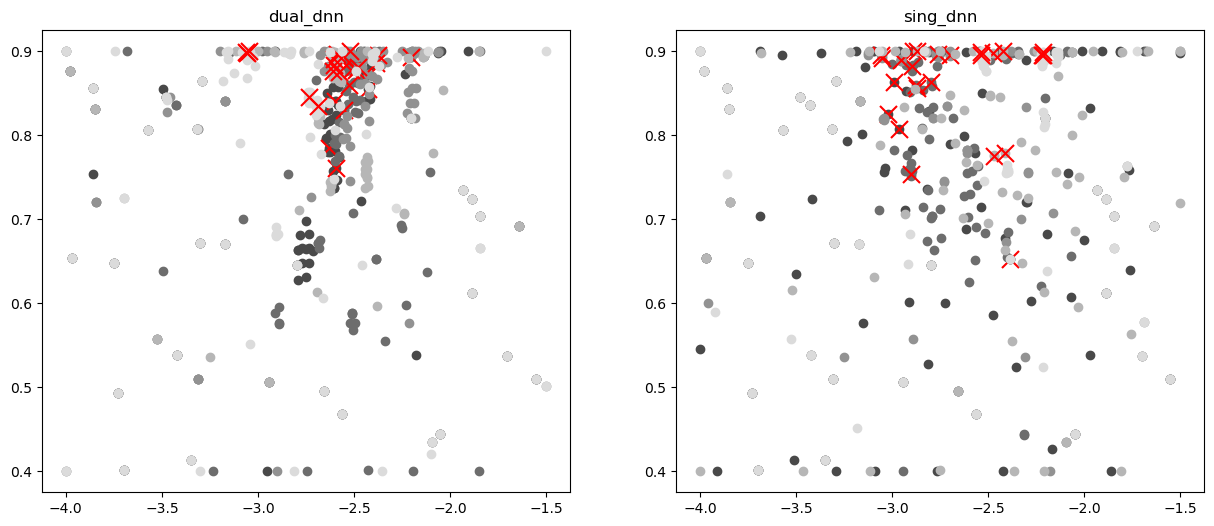

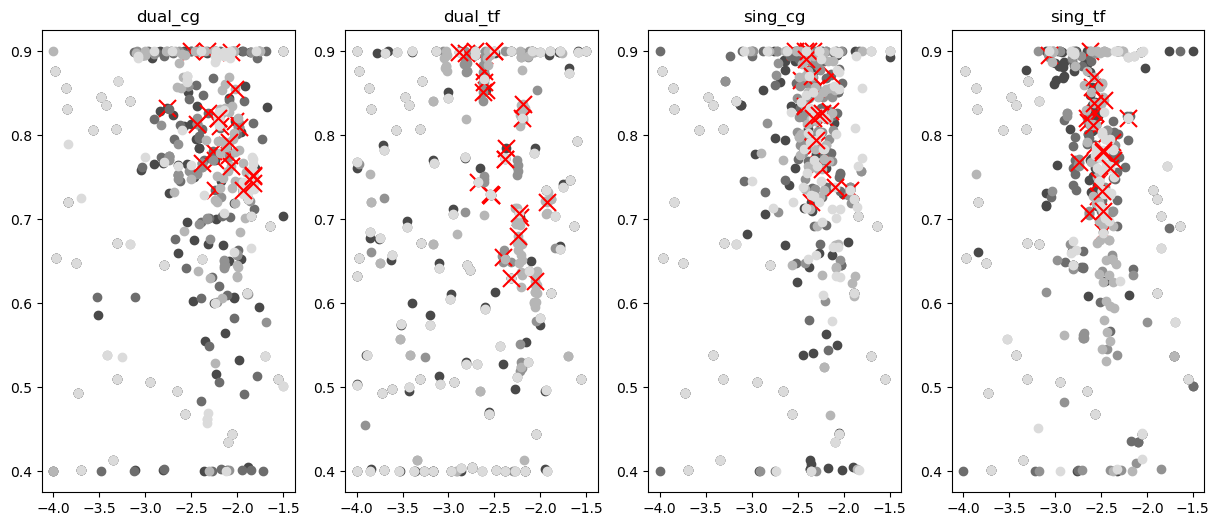

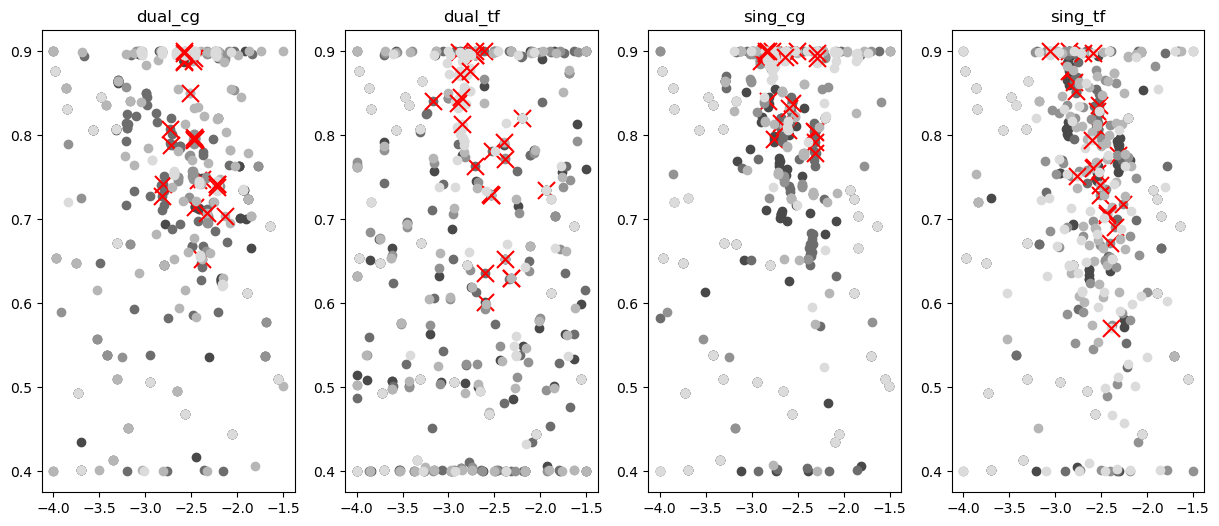

In [380]:
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/bo_r2_failed/finetune_n3c1i-3'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_3/finetune_n3c1i-2'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_3/finetune_n3c1i-3'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_3/finetune_n3c1i-1'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/scratch'
top_k = 5
for model in ['mol','graph','concat']:
    path_model = os.path.join(root, model)
    if not os.path.isdir(path_model): continue
    f, axs = plt.subplots(1, len(os.listdir(path_model)), figsize=(15, 6))
    axs = np.array(axs).reshape(-1)
    for ax, tag in zip(axs, sorted(os.listdir(path_model))):
        path_tag = os.path.join(path_model, tag)
        ax.set_title(tag)
        mats = []
        for i in range(100):
            dn = os.path.join(path_tag, f'n_{i:03d}')
            if not os.path.isdir(dn):
                continue
            fn = os.path.join(dn, 'log_bo.txt')
            ls = []
            with open(fn) as f:
                for l in f.readlines():
                    if 'best' in l:
                        l = l.replace(' - best','')
                        best = int(l.split()[1])
                    _, _, _, _, lr, _, _, gam, _, tr, tm, _, vr, vm, _, fr, fm = l.split()
                    ls.append([lr, gam, tr, tm, vr, vm, fr, fm])
            mat = np.array(ls).astype(float).T
            mat[0] = np.log10(mat[0])
            s = mat[2] + mat[4] - mat[3]*0.1 - mat[5]*0.1
            idx = np.argsort(s)[::-1]
            mat = mat[:, idx]
            mats.append(mat)
        for i, mat in enumerate(mats):
            l = (i+2)/(len(mats)+2)
            ax.scatter(mat[0], mat[1], color=[l,l,l])
            ax.scatter(mat[0,:top_k], mat[1,:top_k], color=[1,0,0], marker='x', s=150)

(array([ 2.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  4.,  0.,  1.,  1.,  1.,
         0.,  3.,  4.,  1.,  8.,  5., 14.,  8., 11., 14., 17.,  7.,  6.,
        11.,  9., 12., 14., 11., 15., 18., 14.,  9., 13.,  7., 11.,  9.,
         6.,  4.,  5.,  3.,  2.,  1.,  3.,  1.,  2.,  2.,  2.]),
 array([-29.23 , -25.792, -22.354, -18.916, -15.478, -12.04 ,  -8.602,
         -5.164,  -1.726,   1.712,   5.15 ,   8.588,  12.026,  15.464,
         18.902,  22.34 ,  25.778,  29.216,  32.654,  36.092,  39.53 ,
         42.968,  46.406,  49.844,  53.282,  56.72 ,  60.158,  63.596,
         67.034,  70.472,  73.91 ,  77.348,  80.786,  84.224,  87.662,
         91.1  ,  94.538,  97.976, 101.414, 104.852, 108.29 , 111.728,
        115.166, 118.604, 122.042, 125.48 , 128.918, 132.356, 135.794,
        139.232, 142.67 ]),
 <BarContainer object of 50 artists>)

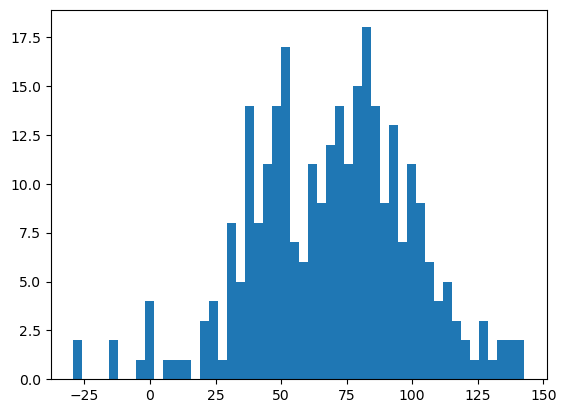

In [55]:
df = pd.read_csv('../dataset/fpolymers_221123.csv')
tgs = df.TG[~df.TG.isna()].values
plt.hist(tgs, bins=50)

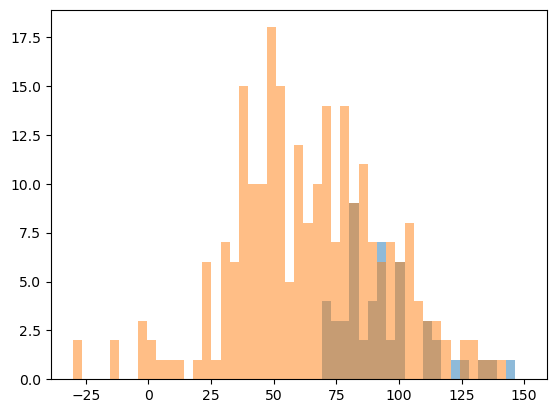

In [87]:
np.random.seed(100)
test_mask = tgs > 70
idxs = np.where(test_mask)[0]
np.random.shuffle(idxs)
test_mask[idxs[50:]] = False
plt.hist(tgs[test_mask], bins=np.linspace(-30, 150, 50), alpha=0.5)
_ = plt.hist(tgs[~test_mask], bins=np.linspace(-30, 150, 50), alpha=0.5)
#tgs

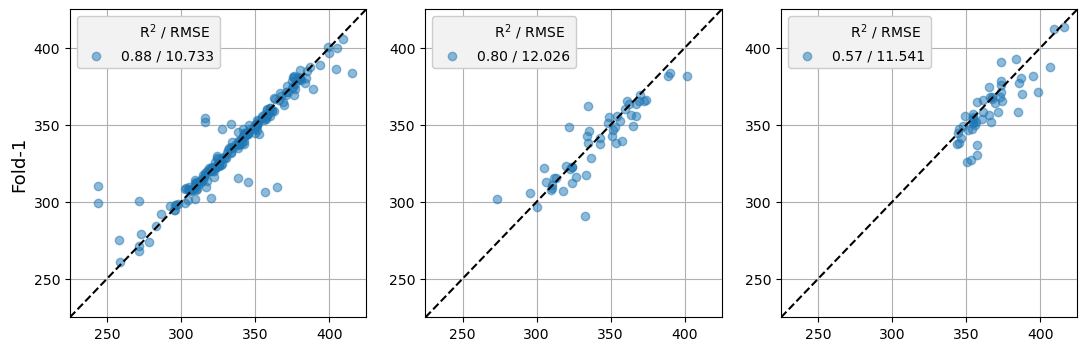

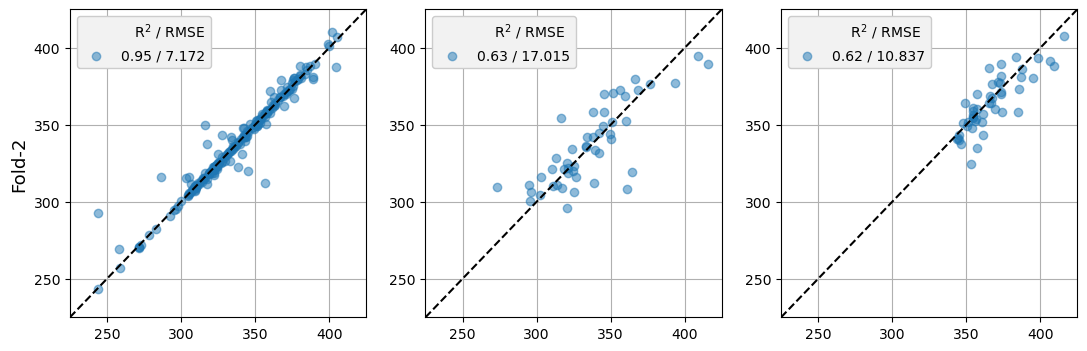

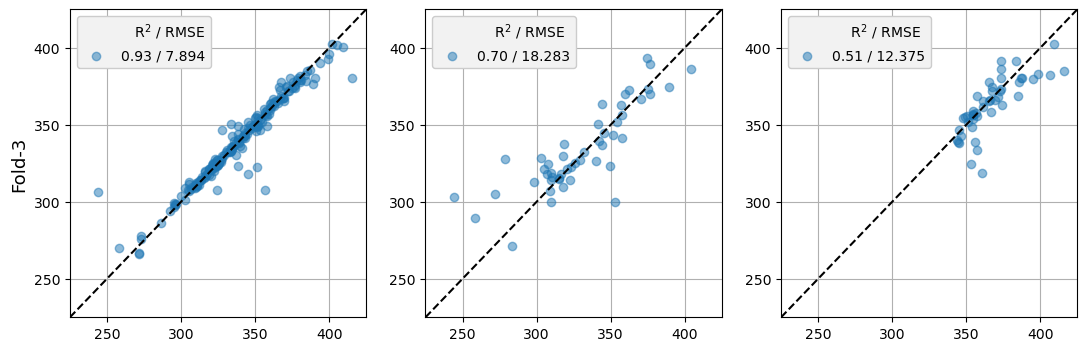

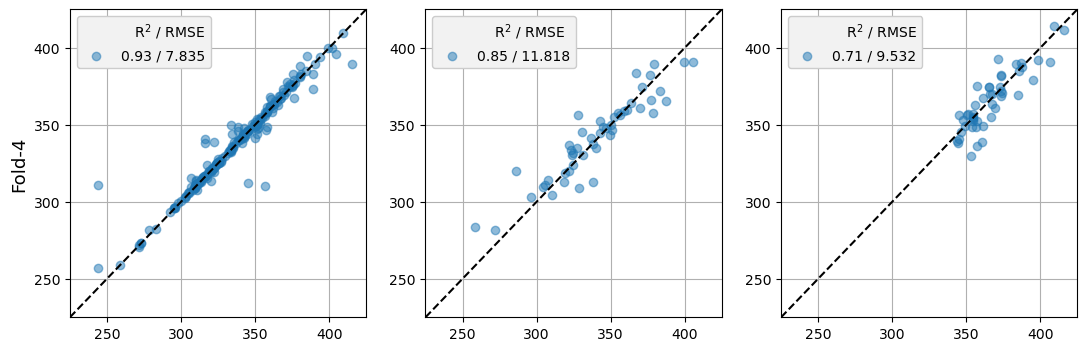

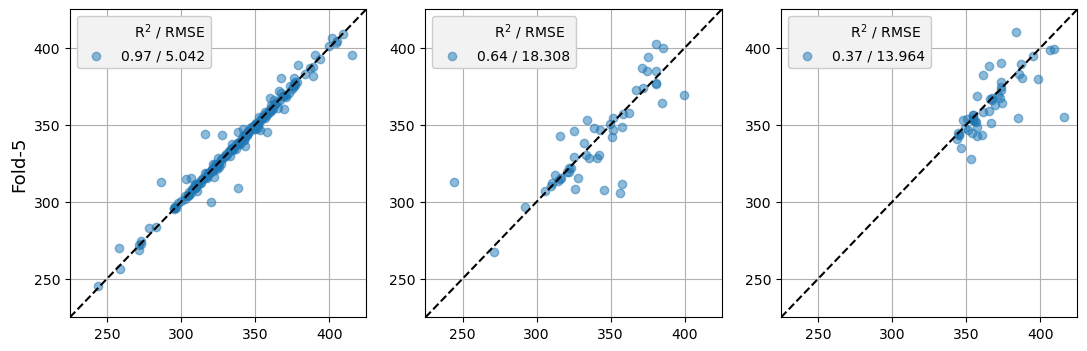

In [7]:
def get_output(root):
    output = {}
    for fn in os.listdir(root):
        if not fn.endswith('pkl'): continue
        if not fn.startswith('best'): continue
        k = fn.split('.')[0]
        if k not in output.keys():
            output[k] = [[], [], []]
        idx = ['train','valid','test'].index(fn.split('.')[1])
        i, t, p = read_data(os.path.join(root, fn)).values()
        output[k][idx] = [i, t, p]
    return {k:v for k,v in sorted(output.items(), key=lambda x: x[0])}

root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/finetune_e3/graph/dual_cg/'
for i in range(5):
    out = get_output(os.path.join(root, f'n_00{i}'))
    f, axs = plt.subplots(len(out), 3, figsize=(13, 4*len(out)))
    axs = axs.reshape(-1,3)
    for ax, (k, _out) in zip(axs, out.items()):
        ax[0].set_ylabel(f'Fold-{i+1}', fontsize=13)
        for _ax, (i, t, p) in zip(ax, _out):
            plot_scatter(_ax, t+273.15, p+273.15, alpha=0.5, xrange=[225, 425])
            _ax.set_xticks([250 + i*50 for i in range(4)])
            _ax.set_yticks([250 + i*50 for i in range(4)])
            _ax.grid()

In [6]:
valid = []
test  = []    
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/finetune_e3/graph/dual_cg/'
for i in range(5):
    _, v, t = get_output(os.path.join(root, f'n_00{i}'))['best']
    valid.append(v)
    test.append(t)


In [411]:
vt = np.hstack([v[1] for v in valid])
vp = np.hstack([v[2] for v in valid])
tt = test[0][1]
tp = np.stack([v[2] for v in test])

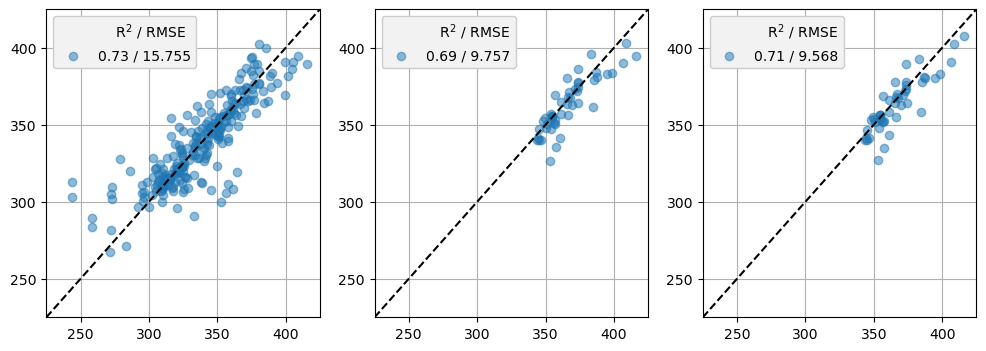

In [419]:
f, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_scatter(axs[0], vt+273.15, vp+273.15, alpha=0.5, xrange=[225, 425])
plot_scatter(axs[1], tt+273.15, np.mean(tp, axis=0)+273.15, alpha=0.5, xrange=[225, 425])
plot_scatter(axs[2], tt+273.15, np.median(tp, axis=0)+273.15, alpha=0.5, xrange=[225, 425])

for ax in axs:
    ax.set_xticks([250 + i*50 for i in range(4)])
    ax.set_yticks([250 + i*50 for i in range(4)])
    ax.grid()

In [65]:
json.load(open(os.path.join(root, 'scale.json')))

{'avg': [64.32917785644531], 'div': [78.5750732421875]}

In [62]:
i, t, p = out['best'][1]
i[np.abs(t - p) > 50]

array(['FA-00247', 'FA-00410'], dtype='<U8')

In [97]:
pdf = df[~df.TG.isna()]
pdf[test_mask].to_csv('../dataset/fpolymers_221123.test.csv', index=False)
pdf[~test_mask].to_csv('../dataset/fpolymers_221123.train.csv', index=False)

In [284]:
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(100)
n1 = np.sum(~test_mask)
t1 = tgs[~test_mask]
n2 = np.sum(test_mask)
t2 = tgs[test_mask]

trains = []
tests = []
for s in [0.01, 0.05, 0.1, 0.2, 0.3]:
    for _ in range(int(s * 10000)):
        p1 = t1/np.random.normal(loc=1, scale=s, size=n1)
        p2 = t2/np.random.normal(loc=1, scale=s, size=n2)
        trains.append([r2_score(t1, p1), mean_absolute_error(t1, p1)])
        tests.append([r2_score(t2, p2), mean_absolute_error(t2, p2)])
        
r2_1, mae_1 = np.array(trains).T
r2_2, mae_2 = np.array(tests).T

(0.0, 1.1)

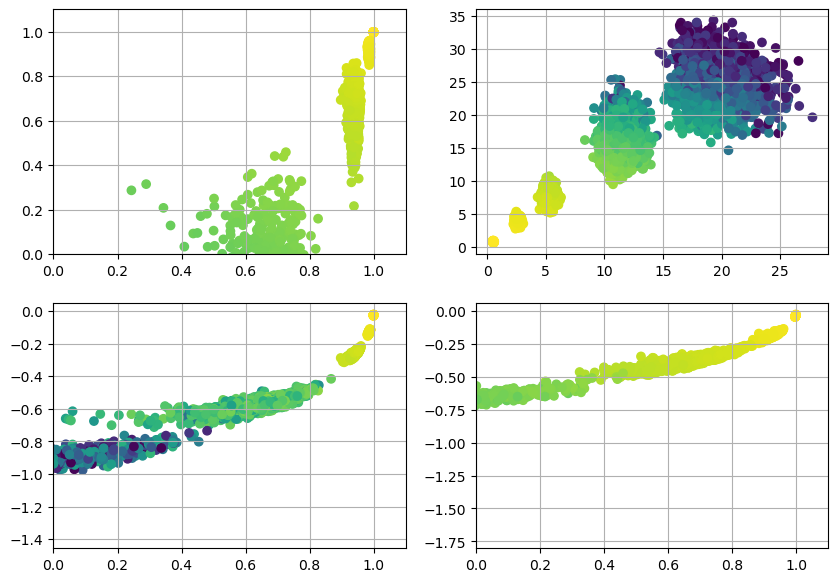

In [290]:
f, axs = plt.subplots(2, 2, figsize=(10,7))
m2_1 = -mae_1 * 0.05
m2_2 = -mae_2 * 0.05
m = r2_1 + r2_2 + m2_1 + m2_2
mask = m > -10
for ax in axs.reshape(-1): ax.grid()
axs[0, 0].scatter(r2_1[mask], r2_2[mask], c=m[mask])
axs[0, 0].set_xlim([0,1.1])
axs[0, 0].set_ylim([0,1.1])
axs[0, 1].scatter(mae_1[mask], mae_2[mask], c=m[mask])
axs[1, 0].scatter(r2_1[mask], m2_1[mask], c=m[mask])
axs[1, 1].scatter(r2_2[mask], m2_2[mask], c=m[mask])
axs[1, 0].set_xlim([0,1.1])
axs[1, 1].set_xlim([0,1.1])


(0.0, 1.1)

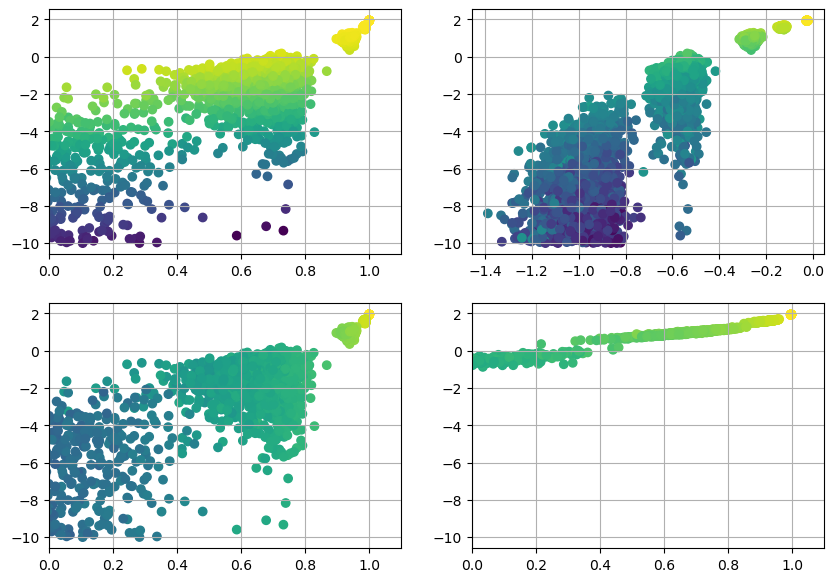

In [289]:
f, axs = plt.subplots(2, 2, figsize=(10,7))
m2_1 = -mae_1 * 0.05
m2_2 = -mae_2 * 0.05
m = r2_1 + r2_2 + m2_1 + m2_2
mask = m > -10
for ax in axs.reshape(-1): ax.grid()
axs[0, 0].scatter(r2_1[mask], m[mask], c=r2_2[mask])
axs[0, 0].set_xlim([0,1.1])
axs[0, 1].scatter(m2_1[mask], m[mask], c=m2_2[mask])
axs[1, 0].scatter(r2_1[mask], m[mask], c=m2_1[mask])
axs[1, 1].scatter(r2_2[mask], m[mask], c=m2_2[mask])
axs[1, 0].set_xlim([0,1.1])
axs[1, 1].set_xlim([0,1.1])


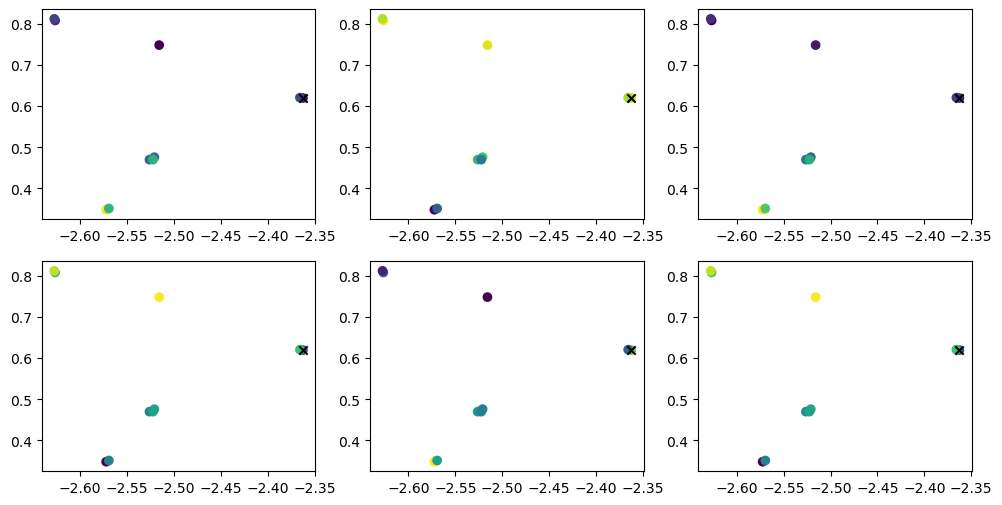

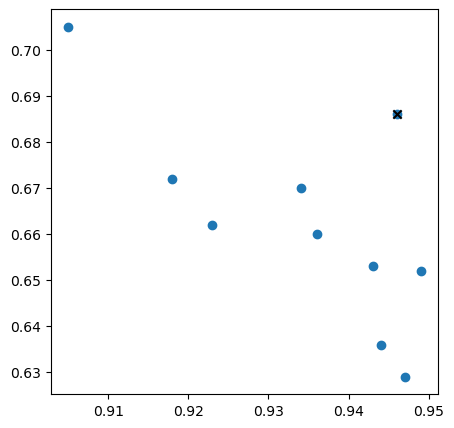

In [25]:
f, axs = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axs.reshape(-1)):
    ax.scatter(mat[0], mat[1], c=mat[i+2])
    ax.scatter(mat[0,0], mat[1,0], color=[0,0,0], marker='x')
f, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(mat[3], mat[6])
ax.scatter(mat[3,0], mat[6,0], color=[0,0,0], marker='x')


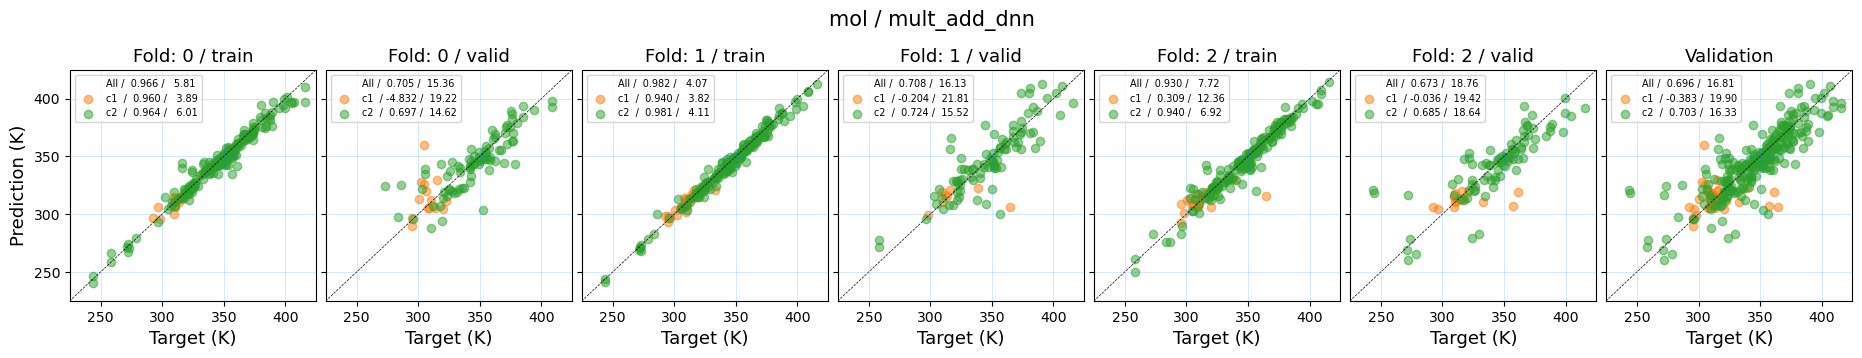

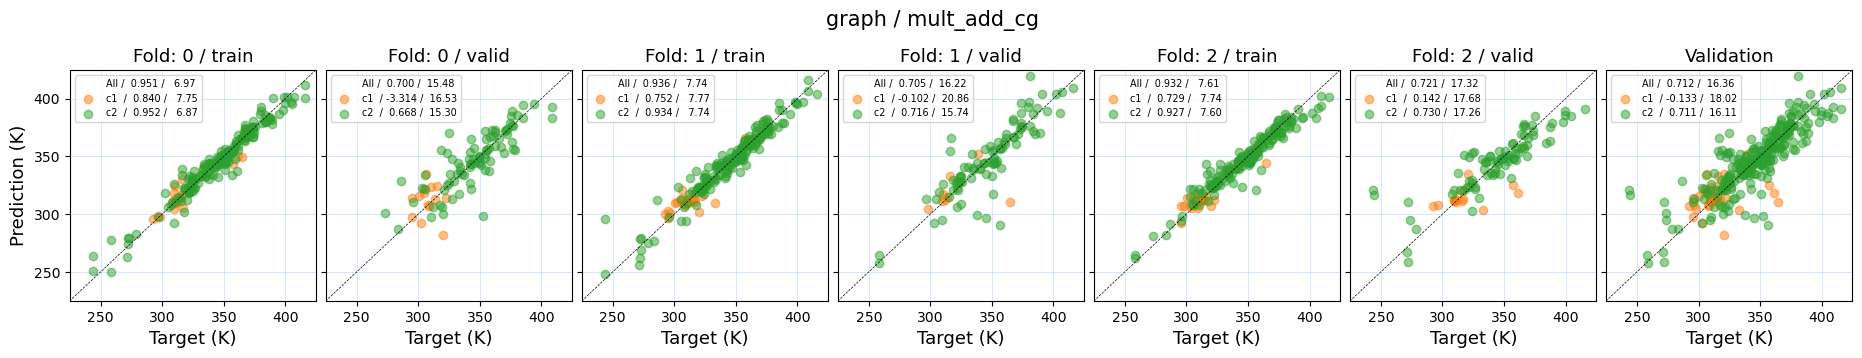

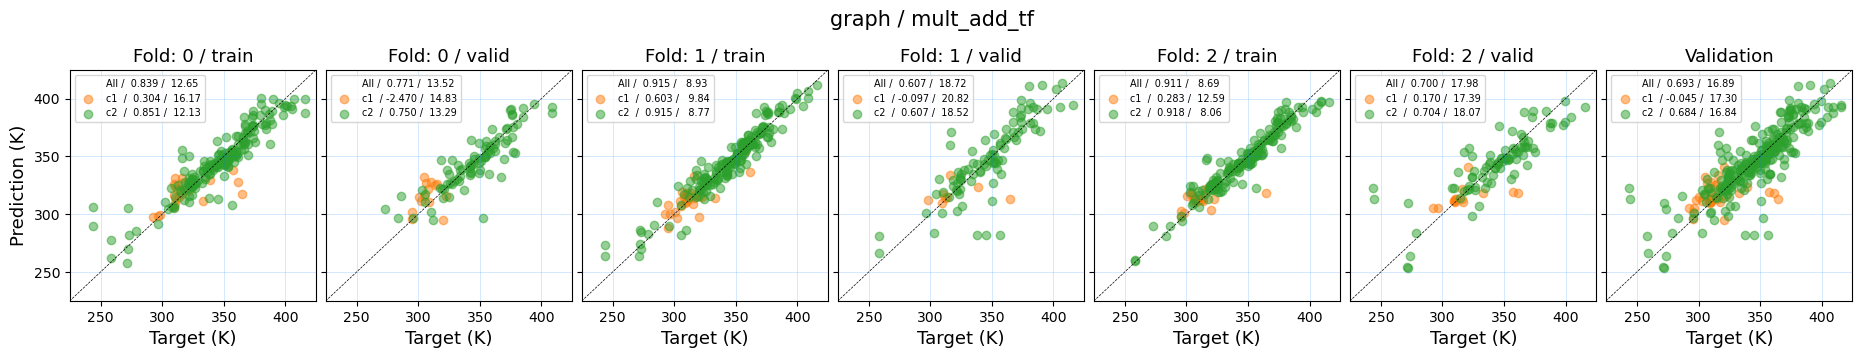

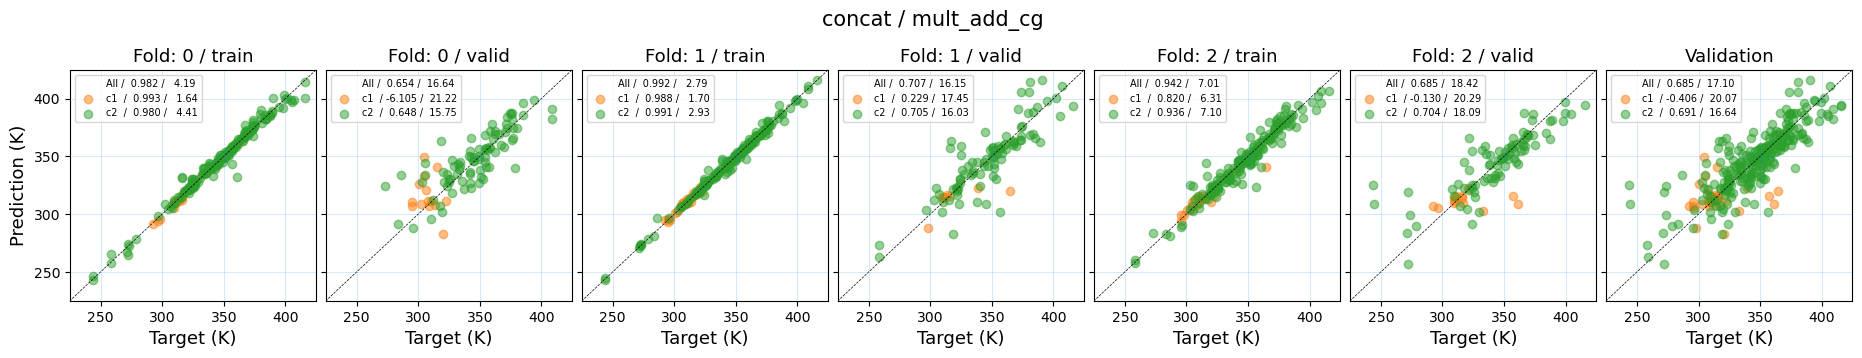

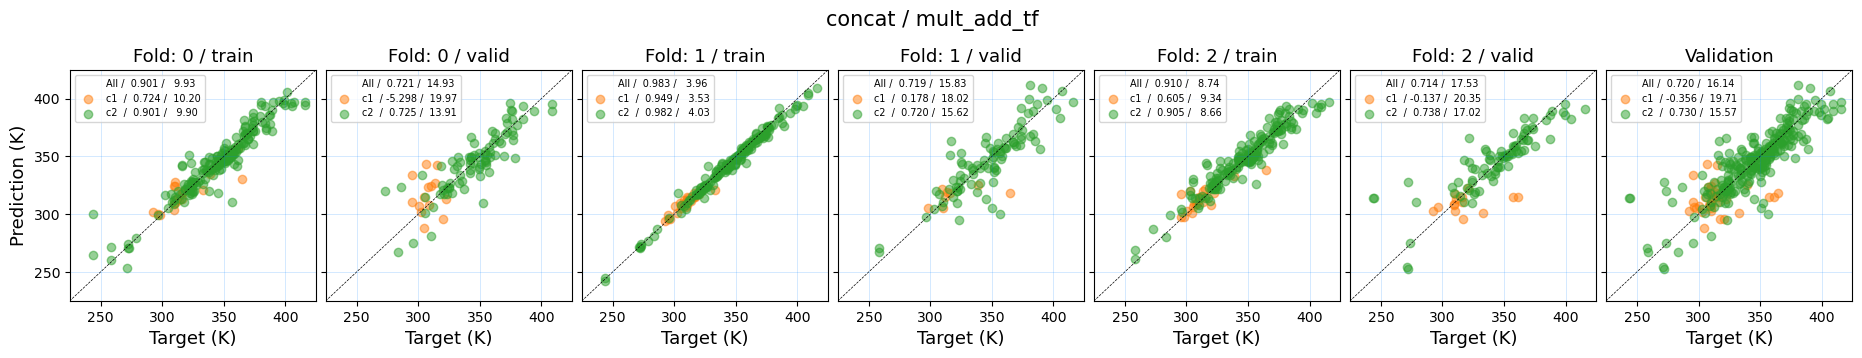

In [275]:
trange = [225, 425, ]
for model in ['mol','graph','concat']:
    output = {}
    path_model = os.path.join(root, model)
    if not os.path.isdir(path_model): continue
    for tag in sorted(os.listdir(path_model)):
        path_tag = os.path.join(path_model, tag)
        output[tag] = {'train':{g:[] for g in train_group_list}, 
                       'valid':{g:[] for g in train_group_list}}
        for i in range(100):
            dn = os.path.join(path_tag, f'cv_{i:04d}')
            if not os.path.isdir(dn):
                continue
            for ds in ['train','valid']:
                data = {g:[] for g in train_group_list}
                dfn = os.path.join(dn, f'{epoch}.{ds}.pkl')
                if not os.path.isfile(dfn): continue
                out = read_data(dfn)
                for id, t, p in zip(out['id'], out['target'], out['pred']):
                    for g in train_group[id]:
                        if g not in train_group_list: continue
                        data[g].append([t, p])
                for g, d in data.items():
                    output[tag][ds][g].append(d)

        f, axs = plt.subplots(1,7,figsize=(23, 3), sharex=True, sharey=True)
        for i, (ds, d3) in enumerate(output[tag].items()):
            for j in range(3):
                axs[j*2 + i].set_title(f'Fold: {j} / {ds}', fontsize=13)
                for g in ['All','c1','c2']:
                    if len(d3[g]) <= j: continue
                    if len(d3[g][j]) == 0: continue
                    t, p = np.array(d3[g][j]).T + 273.15
                    lbl = '{:3s} / {:6.3f} / {:6.2f}'.format(g, r2_score(t,p), np.sqrt(mean_squared_error(t,p)))
                    if g != 'All':
                        axs[j*2 + i].scatter(t, p, alpha=0.5, label=lbl)
                    else: 
                        axs[j*2 + i].scatter([300], [300], alpha=0, label=lbl)
        for g in ['All','c1','c2']:
            v = np.vstack(output[tag]['valid'][g])
            if len(v) == 0: continue
            t, p = v.T + 273.15
            lbl = '{:3s} / {:6.3f} / {:6.2f}'.format(g, r2_score(t,p), np.sqrt(mean_squared_error(t,p)))
            if g != 'All':
                axs[-1].scatter(t, p, alpha=0.5, label=lbl)
            else: 
                axs[-1].scatter([300], [300], alpha=0, label=lbl)
        for ax in axs:
            ax.legend(loc='upper left', fontsize=7)
            ax.set_xlabel('Target (K)', fontsize=13)
            ax.set_xlim(trange)
            ax.set_ylim(trange)
            ax.plot([-200,500],[-200,500], ls='--', lw=0.5, color=[0,0,0])
            for v in [250, 300, 350, 400]:
                ax.axvline(v, lw=0.4, color=[0, 0.5, 1], alpha=0.3)
                ax.axhline(v, lw=0.4, color=[0, 0.5, 1], alpha=0.3)
            ax.set_yticks([])
        axs[0].set_ylabel(f'Prediction (K)', fontsize=13)
        axs[0].set_yticks([250, 300, 350, 400], labels=[250, 300, 350, 400])
        axs[-1].set_title('Validation', fontsize=13)
#        for ax in axs:
        f.suptitle(f'{model} / {tag}', fontsize=15, y=1.08)
        f.subplots_adjust(wspace=0.04)

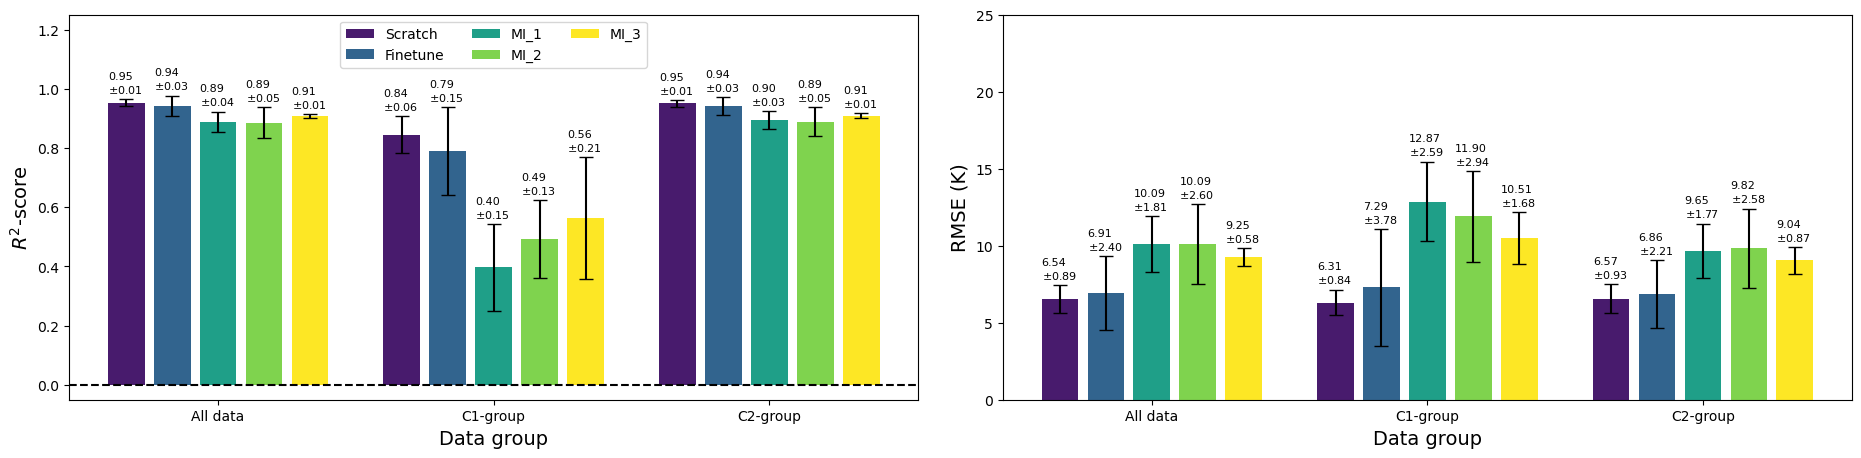

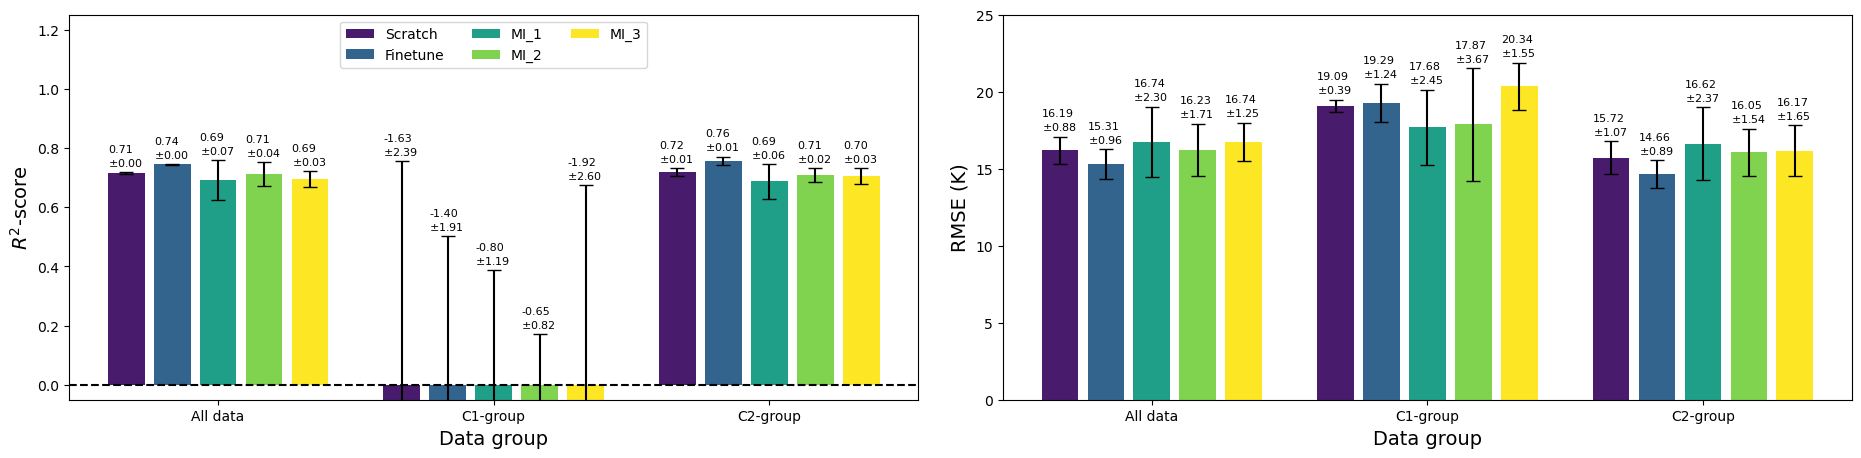

In [351]:
dataset = {
    'train':{
         '$R^2$-score':{
            'all':[[0.953,  0.012],  [0.943,  0.034],  [0.888,  0.035],  [0.886,  0.053],  [0.908,  0.006]],
            'c1': [[0.845,  0.063],  [0.79 ,  0.148],  [0.397,  0.146],  [0.493,  0.132],  [0.563,  0.207]],
            'c2': [[0.951,  0.012],  [0.943,  0.03 ],  [0.895,  0.031],  [0.889,  0.05 ],  [0.909,  0.009]]
        },
        'RMSE (K)':{
            'all':[[6.543, 0.889], [6.912, 2.404], [10.089, 1.812], [10.09,  2.595], [ 9.246, 0.582]],
            'c1' :[[6.313, 0.838], [7.288, 3.781], [12.869, 2.592], [11.902, 2.937], [10.512, 1.677]],
            'c2' :[[6.567, 0.929], [6.858, 2.208], [ 9.653, 1.774], [ 9.821, 2.581], [ 9.041, 0.870]]
        }        

#        '$R^2$-score':{
#            'all':[[ 0.640, 0.040], [0.660, 0.060],[0.850, 0.010],[0.880, 0.020],],
#            'c1': [[-0.330, 0.150], [0.000, 0.000],[0.190, 0.080],[0.000, 0.000],],
#            'c2': [[ 0.630, 0.050], [0.660, 0.060],[0.860, 0.010],[0.880, 0.020],]
#        },
#        'RMSE (K)':{
#            'all':[[18.240, 0.660], [17.390, 1.460], [11.600, 0.850], [10.120, 0.990]],
#            'c1':[[19.020, 1.480], [0.000, 0.000], [14.940, 1.630], [0.000, 0.000]],
#            'c2':[[18.130, 0.640], [17.390, 1.460], [11.050, 0.710], [10.120, 0.990]]
#        }        
    },
    'valid':{
        '$R^2$-score':{
            'all':[[0.715,  0.004], [  0.745,  0.002], [  0.693,  0.067], [  0.713,  0.04 ], [  0.695,  0.027]],
            'c1': [[-1.63,  2.386], [ -1.402,  1.905], [ -0.799,  1.187], [ -0.646,  0.819], [ -1.922,  2.596]],
            'c2': [[0.72 ,  0.013], [  0.756,  0.015], [  0.687,  0.06 ], [  0.709,  0.024], [  0.705,  0.026]]
        },
        'RMSE (K)':{
            'all':[[16.189, 0.884], [15.307, 0.965], [16.737, 2.296], [16.225, 1.705], [16.738, 1.245]],
            'c1' :[[19.094, 0.394], [19.290, 1.237], [17.678, 2.454], [17.874, 3.674], [20.345, 1.546]],
            'c2' :[[15.718, 1.075], [14.659, 0.886], [16.625, 2.368], [16.054, 1.540], [16.168, 1.646]]
        }        

#        '$R^2$-score':{
#            'all':[[0.560, 0.040], [0.540, 0.090], [0.670, 0.070], [0.720, 0.070]],
#            'c1':[[-1.200, 1.380], [0.000, 0.000], [-1.890, 1.990], [0.000, 0.000]],
#            'c2':[[0.540, 0.080], [0.540, 0.090], [0.690, 0.070], [0.720, 0.070]]
#        },
#        'RMSE (K)':{
#            'all':[[19.980, 0.410], [20.020, 2.230], [17.240, 1.700], [15.670, 2.180]],
#            'c1':[[19.800, 2.830], [0.000, 0.000], [22.150, 2.910], [0.000, 0.000]],
#            'c2':[[20.060, 0.180], [20.020, 2.230], [16.490, 1.710], [15.670, 2.180]],
#        }        
    }    
}
cmap = plt.get_cmap('viridis')
models = ['Scratch','Finetune','MI_1','MI_2','MI_3']
a, b, c = 3, 0.5, 0.4
for k1, ds1 in dataset.items():
    f, axs = plt.subplots(1,2,figsize=(23, 5))
    for ax, (k2, ds2) in zip(axs, ds1.items()):
        ax.set_ylabel(k2, fontsize=14)
        for i, val in enumerate(ds2.values()):
            for j, (v, e) in enumerate(val):
                if i == 0:
                    b_ = ax.bar(i*a + j*b, v, c, color=cmap((j+0.3) / 4.1), label=models[j])
                else:
                    b_ = ax.bar(i*a + j*b, v, c, color=cmap((j+0.3) / 4.1))
                if e != 0:
                    ax.errorbar(i*a + j*b, v, e, color=[0,0,0], capsize=5)
                if v < 1:
                    ax.text(i*a + j*b - b*0.4, v + e + 0.02, f'{v:.2f}\n$\pm${e:.2f}', fontsize=8)
                else:
                    ax.text(i*a + j*b - b*0.4, v + e + 0.4, f'{v:.2f}\n$\pm${e:.2f}', fontsize=8)
        ax.set_xticks([1, 4, 7], labels=['All data','C1-group','C2-group'])
        ax.set_xlabel('Data group', fontsize=14)

    axs[0].legend(loc='upper center', ncol=3)
    axs[0].set_ylim([-0.05,1.25])
    axs[0].axhline(0,ls='--', color=[0,0,0])
    axs[1].set_ylim([0,25])
    f.subplots_adjust(wspace=0.1)


In [301]:
_root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5'
epoch = 'best'#f'{500:05d}'
mets = ['scratch','finetune_e3','finetune_e3i-1','finetune_e3i-2','finetune_e3i-3']
cmap = plt.get_cmap('viridis')
outputs = {}
for met in mets:
    root = os.path.join(_root, met)
    for model in ['mol','graph','concat']:
        if model not in outputs.keys():
            outputs[model] = {}
        path_model = os.path.join(root, model)
        if not os.path.isdir(path_model): continue
        for tag in sorted(os.listdir(path_model)):
            path_tag = os.path.join(path_model, tag)
            if tag not in outputs[model].keys():
                outputs[model][tag] = {m:[[],[],[]] for m in mets}
            for i in range(100):
                dn = os.path.join(path_tag, f'n_{i:03d}')
                if not os.path.isdir(dn):
                    continue
                for ds in ['train','valid', 'test']:
                    dfn = os.path.join(dn, f'{epoch}.{ds}.pkl')
                    if not os.path.isfile(dfn): continue
                    out = read_data(dfn)
                    _, t, p = out['id'], out['target'], out['pred']
                    output[tag][ds].append([r2_score(t, p), np.sqrt(mean_squared_error(t, p)), len(t)])
        outputs[model] = output                    

4

No. 28 ==================
train 	 FA-00281 	   43.20	   94.04	  -50.84
train 	 FA-00381 	    0.10	   54.44	  -54.34
train 	 FA-00412 	   91.50	   32.25	   59.25
train 	* FA-00202 	   50.35	   61.37	  -11.02
train 	* FA-00203 	   72.08	   78.13	   -6.05
train 	* FA-00350 	   45.90	   65.44	  -19.54
train 	* FA-00422 	   29.40	   32.65	   -3.25
test 	* FA-00410 	  -29.23	   58.45	  -87.68
large-var	 86.95    67.53    69.37    30.52    87.32   109.60  median
large-var	 99.54    97.37    99.05    69.47   120.55   82.10  median
large-var	  5.42    18.51    19.31   -21.71    47.54   185.79  mean
No. 12 ==================
train 	 FA-00412 	   91.50	   27.79	   63.71
train 	* FA-00202 	   50.35	   59.00	   -8.65
train 	* FA-00203 	   72.08	   74.39	   -2.31
train 	* FA-00422 	   29.40	   30.14	   -0.74
valid 	* FA-00350 	   45.90	   57.73	  -11.83
test 	* FA-00410 	  -29.23	   57.28	  -86.51
large-var	 86.95    67.53    69.37    30.52    87.32   109.60  median
large-var	 99.54    97.37    99.0

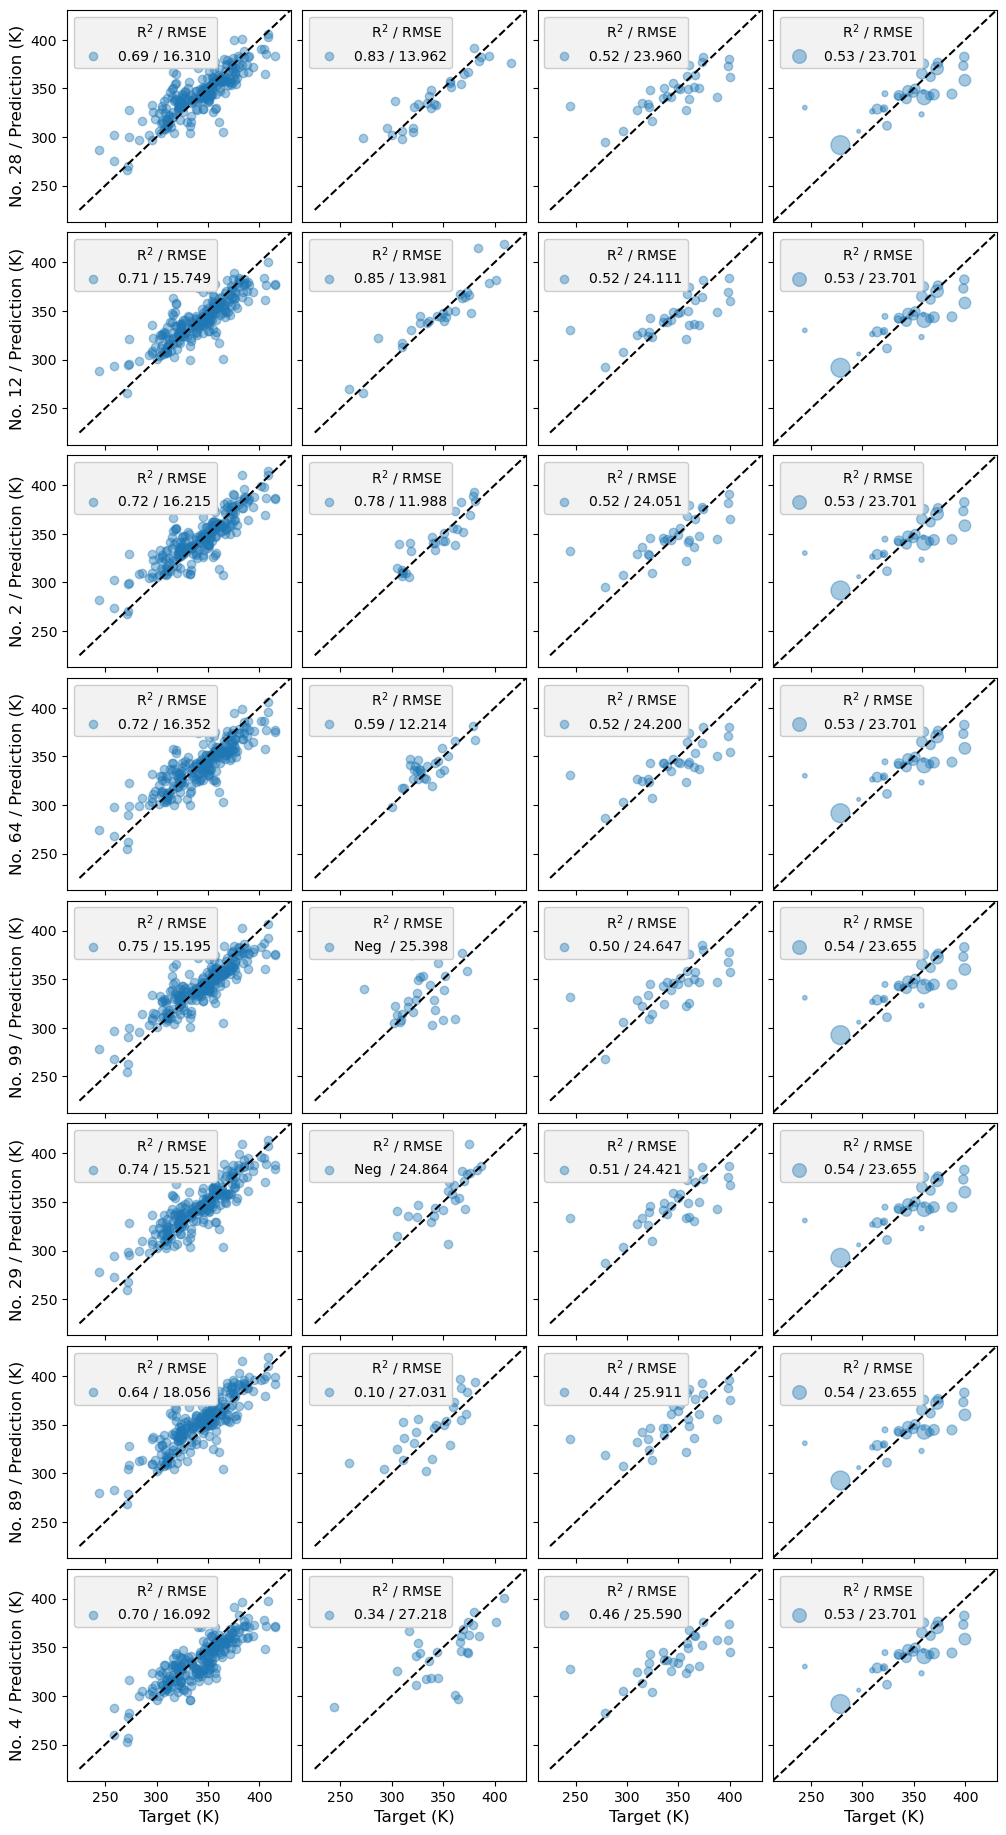

In [279]:
model = 'graph'
tag = 'dual_add_tf'
n = 2
inspect = ['FA-00202','FA-00203','FA-00350','FA-00410','FA-00422']
out = outputs[model][tag]
ems = np.array(ensembles[model][tag]['pred'])
r2, rmse = np.array(out['valid']).T

lr2, hr2 = np.argsort(r2)[:n], np.argsort(r2)[-n:]
lre, hre = np.argsort(rmse)[:n], np.argsort(rmse)[-n:]

f, axs = plt.subplots(4*n, 4, figsize=(12, 23), sharex=True, sharey=True)
for axs_, idxs in zip(axs.reshape(4,n,4), [hr2, lre, lr2, hre]):
    for cax, idx in zip(axs_, idxs):
        print(f'No. {idx} ==================')
        for ax, ds in zip(cax[:-1], ['train','valid','test']):
            fn = f'c_{idx:04d}/00200.{ds}.pkl'
            dfn = os.path.join(root, model, tag, fn)
            if not os.path.isfile(dfn): continue
            data = read_data(dfn)
            ids = data['id']
            target = data['target']
            pred = data['pred']
            for i in np.where(np.abs(target - pred) > 50)[0]:
                if ids[i] in inspect:
                    continue
                print(ds, '\t', ids[i], f'\t{target[i]:8.2f}\t{pred[i]:8.2f}\t{target[i]-pred[i]:8.2f}')
            for id in inspect:
                for j in np.where(id == ids)[0]:
                    print(ds, '\t*', id, f'\t{target[j]:8.2f}\t{pred[j]:8.2f}\t{target[j]-pred[j]:8.2f}')
            plot_scatter(ax, target + 273.15, pred + 273.15, alpha=0.4, xrange=[225, 475])
        var = np.var(ems, axis=0)
        if idx % 2 == 0:
            plot_scatter(cax[-1], target+273.15, np.mean(ems, axis=0)+273.15, alpha=0.4, s=var)
        else:
            plot_scatter(cax[-1], target+273.15, np.median(ems, axis=0)+273.15, alpha=0.4, s=var)
        for j in np.where(var > 80)[0]:
            ems_ = ems[:,j]
            s = f'large-var\t{target[j]:6.2f}   {np.mean(ems_):6.2f}   {np.median(ems_):6.2f}   {np.min(ems_):6.2f}   {np.max(ems_):6.2f}   {var[j]:.2f}'
            if np.abs(target[j] - np.mean(ems_)) > np.abs(target[j] - np.median(ems_)):
                s += '  median'
            else:
                s += '  mean'
            print(s)
        cax[0].set_ylabel(f'No. {idx} / Prediction (K)', fontsize=12)
for ax in axs.T:
    ax[-1].set_xlabel('Target (K)', fontsize=12)
f.subplots_adjust(wspace=0.05, hspace=0.05)